# A search of the plausible attention map

---

Same analysis but without the neutral labels to see how much they will disturb this analysis

In [1]:
%load_ext autoreload
%autoreload 2

import os
from os import path
# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(">> the git rep : ", end="")
print(os.getcwd())

# the folder where we will save our data
plots_folder = os.path.join(os.getcwd(), '.cache', 'plots')
graph_folder = path.join(plots_folder, "auc_head_map")
if not path.exists(path.join(plots_folder, "auc_head_map")):
    os.mkdir(path.join(plots_folder, "auc_head_map"))

print(f">> the plots location : {graph_folder}")

>> the git rep : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm
>> the plots location : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm\.cache\plots\auc_head_map


In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import sklearn.metrics as metrics
import random

from training_bert import BertNliLight
from custom_data_set import SnliDataset
from custom_data_set import test_dir, dev_dir
from torch.utils.data import DataLoader

# --> from this environment
from attention_algorithms.raw_attention import RawAttention
from attention_algorithms.attention_metrics import normalize_attention
from attention_algorithms.attention_metrics import default_plot_colormap
from attention_algorithms.attention_metrics import attention_score

# --> display HTML outputs
from attention_algorithms.plausibility_visu import construct_html_table
from attention_algorithms.plausibility_visu import hightlight_txt
from IPython.display import display, HTML
from ipywidgets import interact_manual



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# load the model

ckp = path.join(".cache", "logs", "igrida_trained", "0", "best.ckpt")
model = BertNliLight.load_from_checkpoint(ckp)
model = model.eval()  # make sure to have the model in eval mod before using it

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## The test data-set to evaluate our metric

In [3]:
# load the data
data_set = SnliDataset(dir=test_dir, nb_sentences=1000, msg=False, keep_neutral=False)
data_loader = DataLoader(data_set, batch_size=1000, shuffle=False)

sentences, masks, train_labels = next(iter(data_loader))

In [4]:
# the data we annotated.
e_snli_data = pd.read_csv(os.path.join('.cache', 'raw_data', 'e_snli', 'cleaned_data', 'test.csv'), sep=",")\
    [["tok_sent", "hg_goal", "label"]]
e_snli_data.head()

,tok_sent,hg_goal,label
0,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral
1,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",entailment
2,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",contradiction
3,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral
4,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",entailment


## The AUC Map

---

The objective here is for each head $h$ of each layer $l$ to have the information whether or not it will provide a plausible explanation. We want to study each head separately to see if some heads are useful and thus prune the useless heads.

As a reminder, for each sentence $s$ composed of $T(s)$ (T is the function that count the number of tokens in a sentence) tokens for each head $h$ and for each layer $l$ we have a matrix $head_{l,h}(s) \in [0,1]^{T(s)\times T(s)}$ This is the attention. Because it is the attention we have the following property :
$$
\sum_{j=0}^{T-1}\quad head_{l,h}(s)[i,j] = 1 \quad \quad \forall i \in \{0,\dots, T-1\}
$$

Because the attention is a result of a softmax.
Then for every token $j$ in our sentence $s$, given a head $h$ and a layer $l$ we will compute its attention score :
$$
a_{h,l}^{j}(s) = \sum_{i=0}^{T-1}\quad head_{l,h}(s)[i,j]\quad \quad \forall j \in \{0,1,\dots,T-1\}
$$

In the next cell for every token of every sentence we will compute this attention score that we will normalize over a sentence, and then for every head $h$ of the layer $l$ we will have $ \hat{a}_{h,l} \in [0,1]^{\mathcal{T}} $ the attention weights calculated for every token that we normalize over each sentence where $\mathcal{T}$ is the number of tokens cumulated on all the sentences of our corpus. Against this vector we will have the vector $e^{snli} \in \{0,1\}^{\mathcal{T}}$ which is the annotation vector for every tokens which comes from the e-snli data-set.


Note : to have a map for the attention we do not have a distribution ($\sum \alpha_i \neq 1 \quad \rightarrow$ saillance map)



In [5]:
# TODO save the pur_attention and adapt the generation

In [8]:
pur_attention, Y_test, _ = attention_score(sentences=sentences, masks=masks,
                                           e_snli_data=e_snli_data,
                                           model=model, TR_q=0,
                                           quantiles_calc=False)

>> start the calculus for 1000 sentences


100%|██████████| 1000/1000 [05:22<00:00,  3.10it/s]

>> nb_errors : 30
>> len Y_test : 25987


Then we have for every head $h$ of every layer $l$, we have the two vectors $\hat{a}_{h,l}$ and $e^{snli}$. The AUC map will only be a matrix $auc\_map\in [0,1]^{L\times H}$ where :
$$
auc\_map[l,h] = AUC(\hat{a}_{h,l}~,~ e^{snli})
$$

With $AUC$ the Area under the roc curve metric.

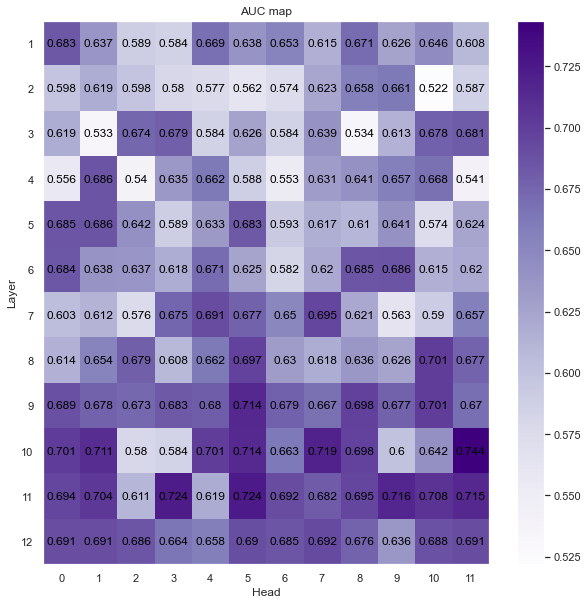

In [9]:
# Construction of the AUC map
auc_map = np.zeros((12, 12))
for l in range(12):
    for h in range(12):
        preds = pur_attention[f"layer_{l}"][f"head_{h}"]
        fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
        auc_map[l, h] = metrics.auc(fpr, tpr)

# plot the color map
fig = default_plot_colormap(auc_map, xlabel="Head", ylabel="Layer", title="AUC map")
plt.savefig(os.path.join(graph_folder, "auc_map.png"))
plt.show()

We can make here some really interesting comments :

- first the maximum value for the *AUC* on this map is $\approx 0.75$. This is a really high *plausibility score*. The *AUC* provided here is much better than the *AUC* provided by the flow max problem
- for every head of every layer we have an *AUC* greater than $0.5$ this means that every layer provide a plausible explanation (better than a random explanation).
- the layer **11** is really interesting and provide an *AUC* score higher than the other layers (a focus on this layer will be made later).
- the heads with an AUC near $0.5$ provide a useless information. $0.5$ is the worst AUC we can obtain.
- we will retain the head 5 of the layer 11. Then to access the best head we will do attention_tensor[0,10,5], the heads are numbered from 0 to 11 but the layers are numbered from 1 to 12 because in the transformers architecture the layer 0 is the non-contextual embedding layer (that we do not study here).

Note : the auc map is calculated on the test dataset

In [10]:
sent_choice = [random.randint(0, 1000) for _ in range(4)]
print(f">> we will look at the sentence : {sent_choice}")

>> we will look at the sentence : [502, 997, 939, 275]


In [11]:
# visualize on the best head
annot = []

for k in sent_choice:
    buff_dict = {}
    sent = sentences[k, :].clone().detach()[None, :]
    mk = masks[k, :].clone().detach()[None, :]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # we will now earch the e-snli corresponding sentence
    j = 0

    while eval(e_snli_data["tok_sent"][j]) != raw_attention_inst.tokens:
        j += 1

    buff_dict["annotation"] = hightlight_txt(raw_attention_inst.tokens,
                                             torch.tensor(eval(e_snli_data.hg_goal[j])))

    # construction of the attention score
    attention_score = raw_attention_inst.attention_tensor[0, 10, 5, :, :].sum(dim=0)
    # noramlization of the score
    attention_score = normalize_attention(raw_attention_inst.tokens, attention_score)

    buff_dict["head (11,5)"] = hightlight_txt(attention=attention_score,
                                              tokens=raw_attention_inst.tokens)

    attention_score = raw_attention_inst.attention_tensor[0, 3, 2, :, :].sum(dim=0)
    # normalization of the score
    attention_score = normalize_attention(raw_attention_inst.tokens, attention_score)

    buff_dict["head (4,2)"] = hightlight_txt(attention=attention_score,
                                             tokens=raw_attention_inst.tokens)
    annot.append(buff_dict)

display(HTML(construct_html_table(annot[0].keys(), annot)))

annotation,"head (11,5)","head (4,2)"
[CLS] a crowd wearing orange cheering for their team in a stadium . [SEP] people wearing orange . [SEP],[CLS] a crowd wearing orange cheering for their team in a stadium . [SEP] people wearing orange . [SEP],[CLS] a crowd wearing orange cheering for their team in a stadium . [SEP] people wearing orange . [SEP]
[CLS] a shirt ##less man with a white hat and no shoes sitting cr ##iss ##cross with his back against the wall holding up a white plastic cup . [SEP] a woman is walking [SEP],[CLS] a shirt ##less man with a white hat and no shoes sitting cr ##iss ##cross with his back against the wall holding up a white plastic cup . [SEP] a woman is walking [SEP],[CLS] a shirt ##less man with a white hat and no shoes sitting cr ##iss ##cross with his back against the wall holding up a white plastic cup . [SEP] a woman is walking [SEP]
[CLS] young man performing a skate ##board trick on a sidewalk in a city . [SEP] there is a guy performing a skill on a skate ##board on the sidewalk in a metropolitan area . [SEP],[CLS] young man performing a skate ##board trick on a sidewalk in a city . [SEP] there is a guy performing a skill on a skate ##board on the sidewalk in a metropolitan area . [SEP],[CLS] young man performing a skate ##board trick on a sidewalk in a city . [SEP] there is a guy performing a skill on a skate ##board on the sidewalk in a metropolitan area . [SEP]
[CLS] a guy and a girl look down a mountain range . [SEP] the people look into the sky . [SEP],[CLS] a guy and a girl look down a mountain range . [SEP] the people look into the sky . [SEP],[CLS] a guy and a girl look down a mountain range . [SEP] the people look into the sky . [SEP]


Here there is clearly two problems to identify :
- first the AUC is perhaps not the best criterion. We selected the heads with the best AUC score ($\approx$0.75), and we have a really bad plausibility (only the dots were underlined).
- we can make the following hypothesis, if we have a bad AUC, it is because the entropia is high (the desorder in the distribution is really high).

In the following we calculate some statistics to be sure of this.

**Note 1** : clearly the *AUC* criterion help us to see the fact that not all heads are used in our plausibility problem, but the AUC will cache some bad information for plausibility problem.

**Note 2** : the $head_{11,5}$ only underlined the dots, clearly this is a really strange behaviour (we have heads of focus only on the punctuation)

## Find a pattern in the bad heads

---

As we saw in the previous graphs, it seems like we have a link between the Heads with a good AUC and the heads

In [12]:
from scipy.stats import entropy, pearsonr, spearmanr

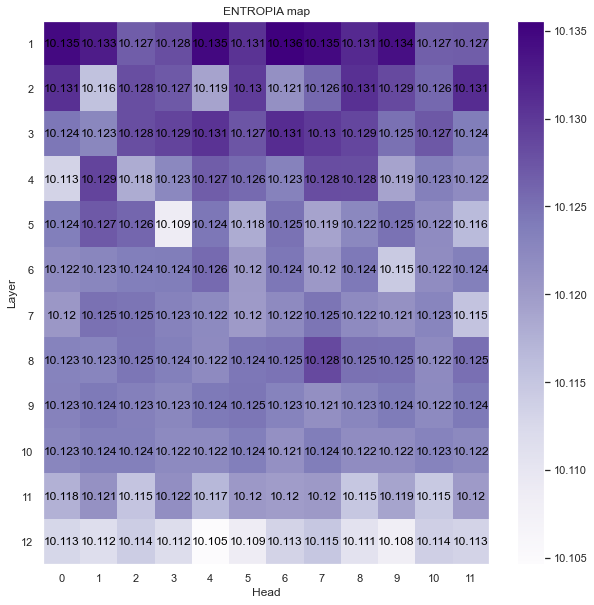

In [13]:
# Construction of the AUC map
entropy_map = np.zeros((12, 12))
for l in range(12):
    for h in range(12):
        preds = pur_attention[f"layer_{l}"][f"head_{h}"]
        # the entropia is calculated on a distribution
        # all the lists have the same length
        entropy_map[l, h] = entropy(pk=np.exp(np.array(preds))/sum(np.exp(np.array(preds))))

# plot the color map
fig = default_plot_colormap(entropy_map, xlabel="Head", ylabel="Layer", title="ENTROPIA map")
plt.savefig(os.path.join(graph_folder, "entropy_map.png"))
plt.show()

some statistics on between the entropia and the AUC : bad AUC = High entropia ?

In [14]:
pr = pearsonr(auc_map.flatten(), entropy_map.flatten())
print(f"p value for the pearson test : {np.round(pr[1], 6) * 100} %")

p value for the pearson test : 2.777 %


In [15]:
spr = spearmanr(auc_map.flatten(), entropy_map.flatten())
print(f"p value for the spearman test : {np.round(spr[1], 6) * 100} %")

p value for the spearman test : 0.39680000000000004 %


After this test we can validate the following hypothesis. The really bad heads, have a really high entropia, then we have really weights on all our datas. But we still have a problem. The heads really sparse or with just one non zero components will have a really bad plausibility then we must find a way to see if we can identify them.

- the new problem is how to identify the heads with a really high AUC, a really low entropia but a really bad plausibility.
- the way we find this criterion will guide us to give the model a good regularization.

## A new criterion for the entropia

---

Based on what we saw just before a bad AUC is synonyme of a a really high entropia and those both caracters lead to a bad head. But a good AUC and a low entropia doesn't mean that we have a good head. Then with this criterion we can't identify all the good heads for our plausibility problem. We need to penalise when we have a really low entropia and thus we will be able to combine the two criterion and then search for good heads. Then we will proceed as follow :
$$
\boxed{\theta(\alpha) = H(\alpha)*(1-H(\alpha))}
$$

We define a new criterion for the calculation of the entropia map.

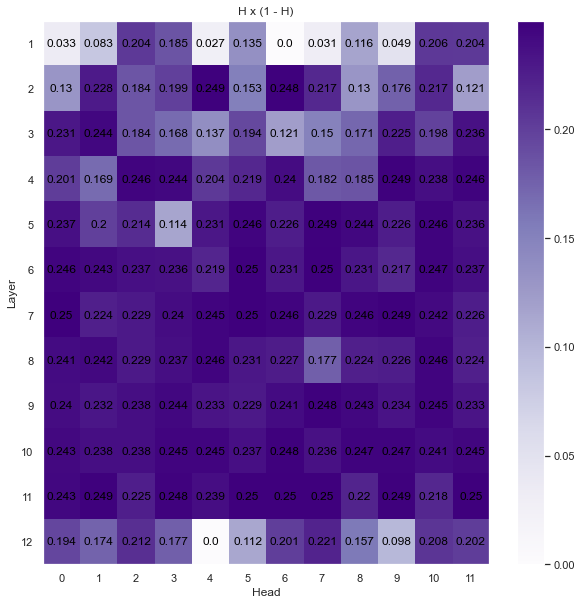

In [16]:
entropy_map_bis = (entropy_map - entropy_map.min())/(entropy_map.max() - entropy_map.min())
entropy_map_bis = entropy_map_bis*(1-entropy_map_bis)

# plot the color map
fig = default_plot_colormap(entropy_map_bis, xlabel="Head", ylabel="Layer", title="H x (1 - H)")
plt.savefig(os.path.join(graph_folder, "entropy_map_mod.png"))
plt.show()

Note : for our regularization, we will try to only apply a regularization only for the layers 7 to 10 (where the information is located)

## Agregation of the "good" heads

---

After this experience we are able te see that some heads are "useless" (the AUC is really close to 0.5) we will then apply a mask to the head to focus on the head with a good AUC. To define a good AUC we need to set a threshold $TR$, and we will keep all the heads that have an AUC greater than this particular treshold

### Entropia based agregation

---

Here we will select some heads that allow us to make a table of annotation. The observation are really empirical but they will help us to find the good regularization criterion for our new fine tuning. The objective is to penalize the heads with a really low entropia (they will contain really few informations).

Once the new fine tuning will be done we will maybe be able to compare the confidence map and the others maps.

In [17]:
# visualize on the best head
annot = []

for k in sent_choice:
    buff_dict = {}
    sent = sentences[k, :].clone().detach()[None, :]
    mk = masks[k, :].clone().detach()[None, :]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # we will now earch the e-snli corresponding sentence
    j = 0

    while eval(e_snli_data["tok_sent"][j]) != raw_attention_inst.tokens:
        j += 1

    buff_dict["annotation"] = hightlight_txt(raw_attention_inst.tokens,
                                             torch.tensor(eval(e_snli_data.hg_goal[j])))

    # construction of the attention score
    attention_score = raw_attention_inst.attention_tensor[0, 10, 5, :, :].sum(dim=0)
    # normalization of the score
    attention_score = np.zeros(len(raw_attention_inst.tokens))
    for l in range(12):
        for h in range(12):
            if entropy_map_bis[l, h] >= 0.24 and auc_map[l, h]>= 0.7:
                attention_score += raw_attention_inst.attention_tensor[0, l, h, :, :].sum(dim=0)\
                    .detach().numpy()
    attention_score = normalize_attention(raw_attention_inst.tokens, torch.tensor(attention_score))

    buff_dict["entropia based agreg"] = hightlight_txt(attention=attention_score,
                                                       tokens=raw_attention_inst.tokens)

    annot.append(buff_dict)

display(HTML(construct_html_table(annot[0].keys(), annot)))

annotation,entropia based agreg
[CLS] a crowd wearing orange cheering for their team in a stadium . [SEP] people wearing orange . [SEP],[CLS] a crowd wearing orange cheering for their team in a stadium . [SEP] people wearing orange . [SEP]
[CLS] a shirt ##less man with a white hat and no shoes sitting cr ##iss ##cross with his back against the wall holding up a white plastic cup . [SEP] a woman is walking [SEP],[CLS] a shirt ##less man with a white hat and no shoes sitting cr ##iss ##cross with his back against the wall holding up a white plastic cup . [SEP] a woman is walking [SEP]
[CLS] young man performing a skate ##board trick on a sidewalk in a city . [SEP] there is a guy performing a skill on a skate ##board on the sidewalk in a metropolitan area . [SEP],[CLS] young man performing a skate ##board trick on a sidewalk in a city . [SEP] there is a guy performing a skill on a skate ##board on the sidewalk in a metropolitan area . [SEP]
[CLS] a guy and a girl look down a mountain range . [SEP] the people look into the sky . [SEP],[CLS] a guy and a girl look down a mountain range . [SEP] the people look into the sky . [SEP]


### Layer Sum agregation

---

We saw during the previous phase that some layers could be pruned be within the "important heads" (the heads we do not prune) each head provide an information different about the plausibility. Our objective is to combine the information gathered by each of these heads. A good way to combine this information is to make the *sum* (sum agregation).

First we will look at the sum layer by layer, we want to keep this approach layer by layer.

In [12]:
if not path.exists(path.join(graph_folder, "layer_agreg")):
    os.mkdir(path.join(graph_folder, "layer_agreg"))

In [76]:
@interact_manual
def layer_combination_TR(TR=(0.5, 0.65, 0.01)):
    auc_mask = (auc_map >= TR)
    pur_attention_bis = {}
    for l in range(12):
        pur_attention_bis[f"layer_{l}"] = []

    for l in range(12):
        buff = None
        it_1 = True
        for h in range(12):
            if auc_mask[l, h]:
                if it_1:
                    buff = np.array(pur_attention[f"layer_{l}"][f"head_{h}"])
                    it_1 = False
                else:
                    buff += np.array(pur_attention[f"layer_{l}"][f"head_{h}"])
        pur_attention_bis[f"layer_{l}"] = list(buff)
    # Construction of the AUC map
    auc_map_bis = np.zeros((12, 1))
    for l in range(12):
        preds = pur_attention_bis[f"layer_{l}"]
        fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
        auc_map_bis[l, 0] = metrics.auc(fpr, tpr)

    # plot the color map
    fig = default_plot_colormap(auc_map_bis, xlabel="ag", ylabel="layer", title="AUC map after agreg")
    plt.savefig(os.path.join(graph_folder, "layer_agreg", f"{TR}.png"))
    plt.show()

interactive(children=(FloatSlider(value=0.5700000000000001, description='TR', max=0.65, min=0.5, step=0.01), B…

### Study of the Layer 11 (push more the threshold)

In [18]:
if not path.exists(path.join(graph_folder, "layer_11")):
    os.mkdir(path.join(graph_folder, "layer_11"))

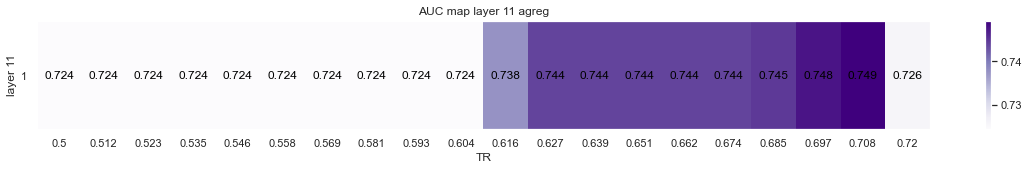

In [23]:
def layer_combination_TR(TR=np.linspace(0.5, 0.72, 20)):
    map = np.zeros((1, len(TR)))
    k = 0
    for tr in TR:
        auc_mask = (auc_map >= tr)
        buff = None
        it_1 = True

        # >> we sum the score of the different heads
        for h in range(12):
            if auc_mask[10, h]:
                if it_1:
                    buff = np.array(pur_attention[f"layer_{10}"][f"head_{h}"])
                    it_1 = False
                else:
                    buff += np.array(pur_attention[f"layer_{10}"][f"head_{h}"])
        # >> we normalize this score
        buff = (buff - buff.min()) / (buff.max() - buff.min())
        fpr, tpr, threshold = metrics.roc_curve(Y_test, np.array(buff))
        map[0, k] = metrics.auc(fpr, tpr)
        k += 1

    # plot the color map
    fig = default_plot_colormap(map, xlabel="TR", ylabel="layer 11", title="AUC map layer 11 agreg",
                                xstick=[str(np.round(i, 3)) for i in TR],
                                sz=(20, 2))
    plt.savefig(os.path.join(graph_folder, "layer_11", f"auc_map_l11_tr.png"))


layer_combination_TR()

If we push more the threshold we have a loss of the AUC score (really sparse heads with a very bad information), but it seems like we have an optimal threshold. This show us something really intresting (for our plausibility problem) :

- a bad auc = a bad head
- a good auc $\neq$ a good head

### A more global agregation

---

Now we will compute some statistical tests to see if we have an interest to remove :
- some layers
- some heads
- interest to focus on the layer 11

Now instead of looking at the global AUC, we will look at the AUC sentences by sentences and try to see if we can improve the.
Our hypothese is that some layers are useless for the plausibility problem.

**Note :** Here we can clearly predict the new result, we combine heads with a good AUC and then we will have a better AUC.

In [10]:
from attention_algorithms.attention_auc_wilcox_test import *

In [11]:
# load the data
data_set = SnliDataset(dir=dev_dir, nb_sentences=1000, msg=False)
data_loader = DataLoader(data_set, batch_size=1000, shuffle=False)

sentences, masks, train_labels = next(iter(data_loader))

# the data we annotated.
e_snli_data = pd.read_csv(os.path.join('.cache', 'raw_data', 'e_snli', 'cleaned_data', 'dev.csv'), sep=",")\
    [["tok_sent", "hg_goal", "label"]]

First we calculate the AUC, with the global agregation (sum of the score of all the heads of all the layers) this is the most intuitive way to construct an attention score. We will then see if we are able to increase this score by choosing the right layers

In [12]:
x = global_auc_score(sentences=sentences,
                     masks=masks,
                     model=model,
                     annot_data=e_snli_data)

In [13]:
# suppression of heads with a low AUC
Y = []
TR_s = np.linspace(0.5, 0.75, 10)
for TR in TR_s:
    Y.append(tr_del_auc_score(sentences=sentences,
                              masks=masks,
                              model=model,
                              annot_data=e_snli_data,
                              TR=TR,
                              auc_map=auc_map)
             )

KeyboardInterrupt: 